In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import dxchange
import functools

astropy module not found
olefile module not found


In [15]:
def makeGaussian(size, fwhm = 3, center=None):
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
def calc_diffractionpattern(obj, probe, shift, N_ph=1.e7):
    ny, nx  = np.shape(probe)
    probe *= np.sqrt(1./np.sum(np.abs(probe)**2)*N_ph/ny/nx)
    obj_cut = obj[shift[1]:shift[1]+ny, shift[0]:shift[0]+nx]
    Psi = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(obj_cut*probe)))
    I = np.abs(Psi)**2
    return np.random.poisson(I)
def obj_patch(obj, probe, shift):
    ny, nx  = np.shape(probe)
    obj_p = obj[shift[1]:shift[1]+ny, shift[0]:shift[0]+nx]
    return obj_p

def ptycho_forward(obj, probe, probe_size, step_size):
#     h_probe, w_probe = probe.shape
    print(obj.shape)
   
    patches = tf.image.extract_patches(obj, 
                                   sizes = [1, probe_size, probe_size, 1], 
                                   strides = [1, step_size, step_size, 1],
                                   rates=[1, 1, 1, 1],
                                   padding='SAME')
    print(patches.shape)
#     probe = tf.complex(probe, 0)
    obj_probe = patches* probe
    psi = tf.signal.fft3d(obj_probe, [1, 2])
#     psi = tf.signal.fftshift(psi, [1, 2])
    return patches, tf.square(tf.abs(psi))
    
    

def phase_fraunhofer(phase, absorption):
    wf = tf.complex(absorption, phase)
    # wf = tf.complex(phase, absorption)

    # wf = mask_img(wf)
    # wf = tf.multiply(ampl, tf.exp(phshift))
    # wf = tf.manip.roll(wf, [160, 160], [0, 1])
    ifp = tf.square(tf.abs(tf.signal.fft2d(wf)))
    ifp = tf.roll(ifp, [256, 256], [0, 1])
    ifp = tf.reshape(ifp, [ifp.shape[0], ifp.shape[1], 1])
    ifp = tf.image.per_image_standardization(ifp)
    ifp = tfnor_phase(ifp)
    return ifp

In [3]:
def siemensstar(N, R0=80, delta=0.05, segments=18, rings_N=10, rings_f=2., downsample=1):  
    if downsample > 1:
        N = int(N*downsample)
        R = R0*downsample
    else:
        R = R0
    y,x = np.mgrid[:N,:N] - N/2
    phi = np.arctan2(-y,x)
    r = np.sqrt(x**2+y**2)
    stripes = 1.0*(np.sin(segments*phi)**2>0.5)

    center = 1.0*(r<R)
    outer = 1.0*(r>R*(rings_f**rings_N))
    rings = np.zeros_like(stripes)

    if rings_N > 1:
        for i in range(rings_N):
            R *= rings_f
            rings += 1.0*(r>=(1-delta)*R)*(r<R)
    star = functools.reduce(np.maximum, [center, rings, stripes, outer])
    if downsample==1:
        return star
    else:
        return np.average(np.average(star.reshape(N/downsample, downsample, N/downsample, downsample), axis=3), axis=1)

In [16]:
N_object = 256
N_probe = 64
step_size = 20
N_ph=1.e7
data = dxchange.read_tiff('/Users/xiaogangyang/test/ph_babara.tiff')[0]
# print(data.shape, data.max(), data.min())
data = data[128:-128, 128:-128]
# print(data.shape, data.max(), data.min())
obj_phase = data

obj_amp = siemensstar(N_object, R0=80, delta=0.05, segments=18, rings_N=10, rings_f=2., downsample=1)


obj = obj_amp*np.cos(-obj_phase) + 1j*obj_amp*np.sin(-obj_phase)
print(obj.dtype)
obj = tf.reshape(obj, [1, 256, 256, 1])
pro_amp = makeGaussian(N_probe, fwhm=(N_probe*0.25))
# obj = obj_amp*np.cos(-obj_phase) + 1j*obj_amp*np.sin(-obj_phase)
probe = pro_amp*np.cos(0.05*pro_amp) + 1j*pro_amp*np.sin(0.05*pro_amp)
ny, nx  = np.shape(probe)
probe *= np.sqrt(1./np.sum(np.abs(probe)**2)*N_ph/ny/nx)
probe = tf.reshape(probe, [1, 64, 64, 1])

# probe_tmp = tf.zeros_like(probe)
# probe = tf.complex(probe, probe_tmp)
print(probe.dtype)

patches, i_diffraction = ptycho_forward(obj, probe, 64, 4)


print('done calculating shifts')
# print(positions.dtype)

complex128
<dtype: 'complex128'>
(1, 256, 256, 1)
(1, 64, 64, 4096)
done calculating shifts


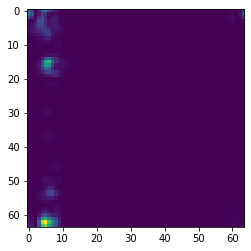

In [14]:
plt.imshow(i_diffraction[0,:,:,100])

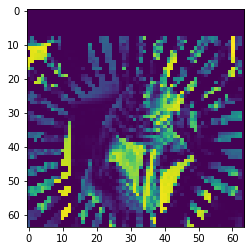

In [20]:
plt.imshow(np.real(patches[0,:,:,100])**2)

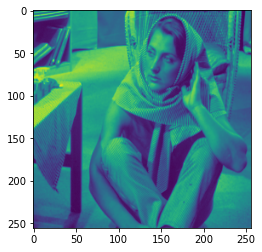

In [97]:
plt.imshow(obj_phase)

In [118]:
test_tmp = np.reshape(obj_phase, (1, 256, 256, 1))

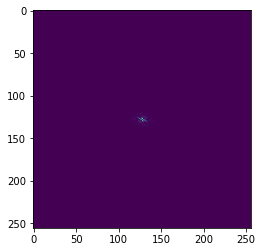

In [142]:
np_fft = np.fft.ifftshift(np.fft.fft2(obj_phase))
plt.imshow(np.imag(np_fft)**2)

In [138]:
fft_tmp = tf.signal.fftshift(tf.signal.fft3d(test_tmp), [1, 2])

In [139]:
a = np.reshape(fft_tmp.numpy(), (256, 256))

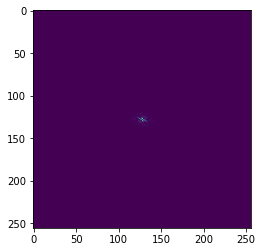

In [140]:
plt.imshow(np.imag(a)**2)

In [113]:
fft_tmp = tf.signal.fftshift(tf.signal.fft2d(obj_phase))

In [112]:
(np.imag(fft_tmp.numpy())**2).max()

33655924.0

In [141]:
dxchange.write_tiff(np.imag(a)**2, '/Users/xiaogangyang/test/fft_test1')

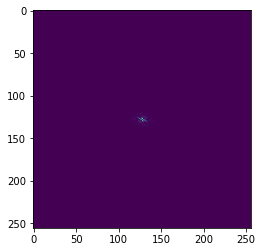

In [114]:
plt.imshow(np.imag(fft_tmp.numpy())**2)

In [99]:
print(fft_tmp.shape)

(256, 256)


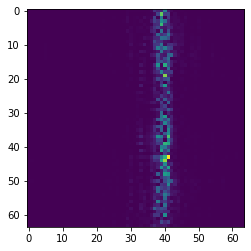

In [96]:
plt.imshow(i_diffraction[0,:,:,120])